Trial 30 Complete [00h 00m 31s]
val_mae: 0.15870076417922974

Best val_mae So Far: 0.10458384454250336
Total elapsed time: 00h 07m 03s
Best Hyperparameters: {'num_gru_layers': 2, 'gru_units_0': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'gru_units_1': 64, 'gru_units_2': 96}
Epoch 1/100
4/4 [==============================] - 3s 231ms/step - loss: 0.1440 - mae: 0.3017 - val_loss: 0.0748 - val_mae: 0.2274
Epoch 2/100
4/4 [==============================] - 0s 42ms/step - loss: 0.0543 - mae: 0.1819 - val_loss: 0.0489 - val_mae: 0.1690
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0494 - mae: 0.1729 - val_loss: 0.0491 - val_mae: 0.1729
Epoch 4/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0383 - mae: 0.1542 - val_loss: 0.0615 - val_mae: 0.2024
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0348 - mae: 0.1466 - val_loss: 0.0336 - val_mae: 0.1409
Epoch 6/100
4/4 [==============================] - 0s 40ms/step - los

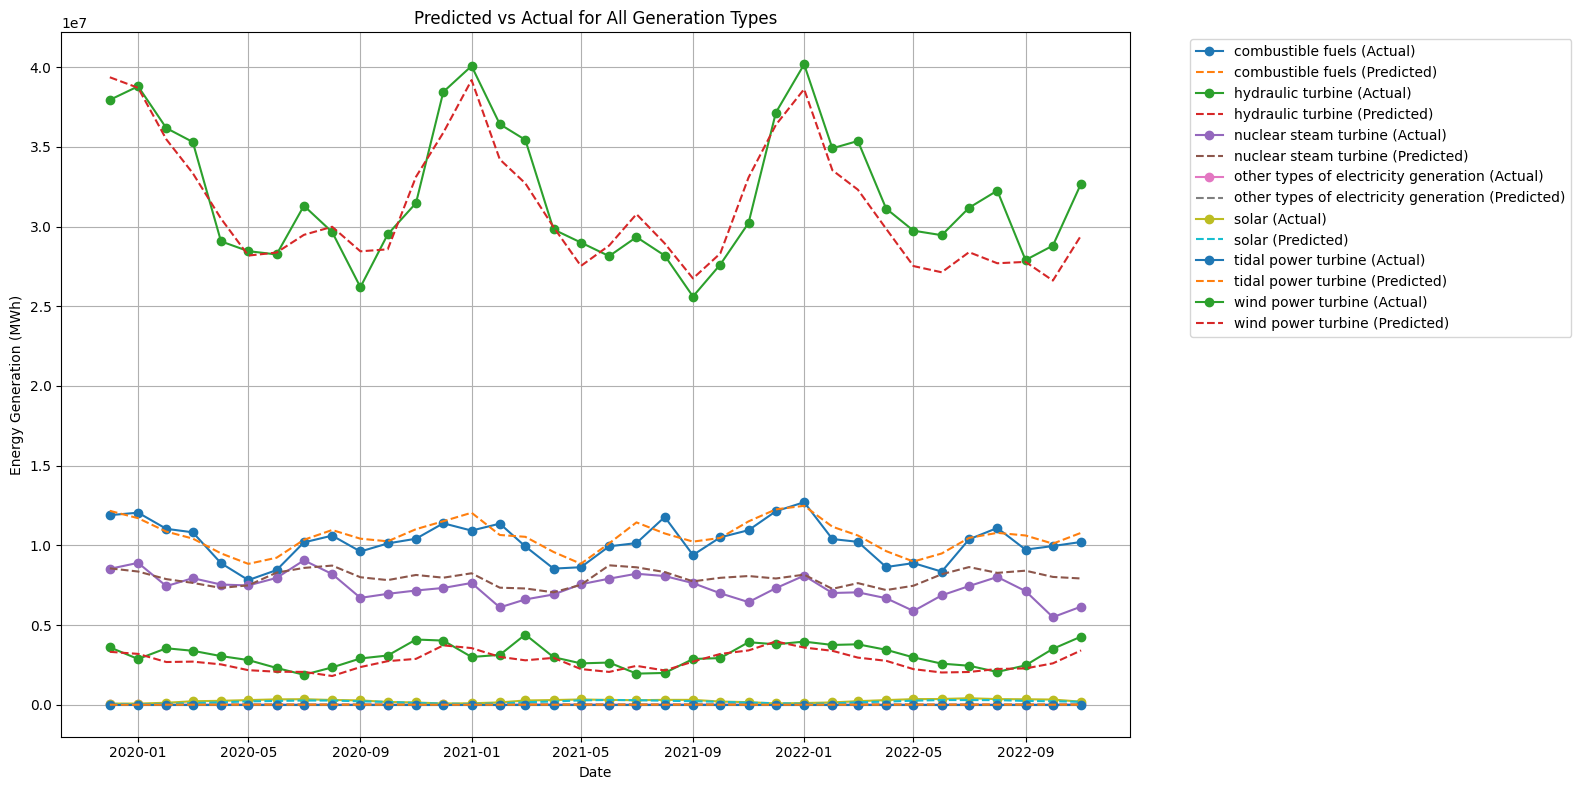

Epoch 1/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0123 - mae: 0.0830
Epoch 2/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0111 - mae: 0.0817
Epoch 3/100
5/5 [==============================] - 0s 31ms/step - loss: 0.0103 - mae: 0.0778
Epoch 4/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0107 - mae: 0.0788
Epoch 5/100
5/5 [==============================] - 0s 35ms/step - loss: 0.0093 - mae: 0.0724
Epoch 6/100
5/5 [==============================] - 0s 34ms/step - loss: 0.0099 - mae: 0.0768
Epoch 7/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0086 - mae: 0.0693
Epoch 8/100
5/5 [==============================] - 0s 35ms/step - loss: 0.0082 - mae: 0.0687
Epoch 9/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0081 - mae: 0.0700
Epoch 10/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0081 - mae: 0.0687
Epoch 11/100
5/5 [==============================] - 0s 38ms/step - lo

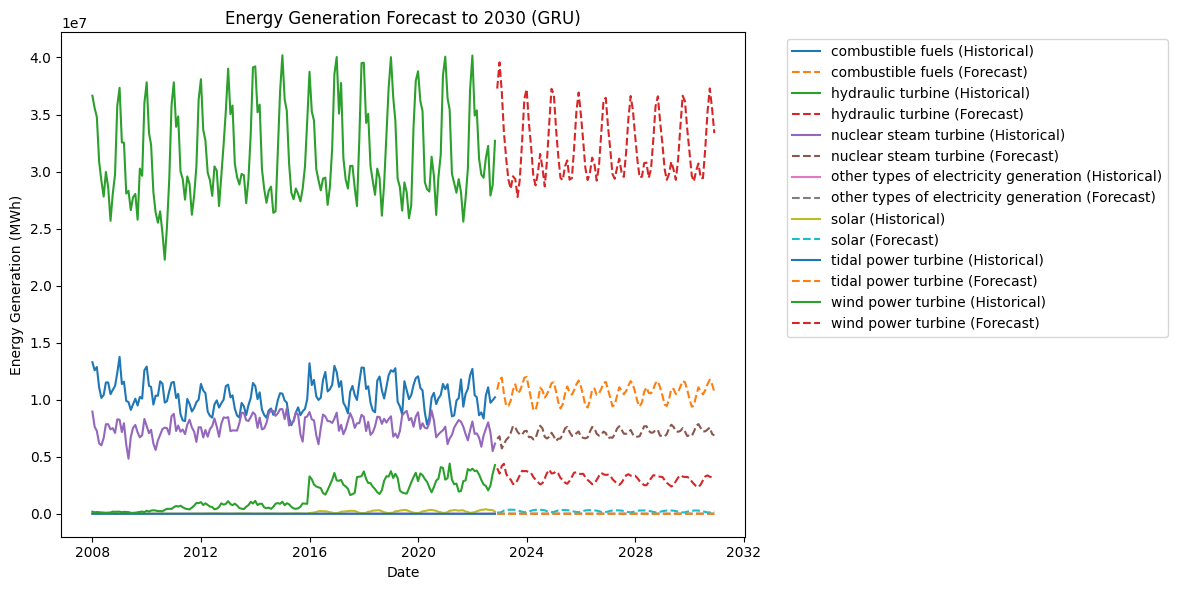

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from kerastuner.tuners import RandomSearch
import tensorflow as tf

# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

# Ensure all generation types are represented for every date
def standardize_generation_types(df, unique_types):
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

# Scale the data
def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Create input-output sequences for time-series data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Define the model for hyperparameter tuning
def build_tuned_gru(hp):
    model = models.Sequential()
    for i in range(hp.Int('num_gru_layers', 1, 3)):  # Number of GRU layers
        if i == 0:  # First GRU layer gets the input shape
            model.add(layers.GRU(
                units=hp.Int(f'gru_units_{i}', min_value=32, max_value=128, step=32),
                return_sequences=True,  # Return sequences for stacking GRU layers
                input_shape=input_shape  # Define input shape for the first layer
            ))
        else:
            model.add(layers.GRU(
                units=hp.Int(f'gru_units_{i}', min_value=32, max_value=128, step=32),
                return_sequences=i < (hp.get('num_gru_layers') - 1)  # Only the last layer should not return sequences
            ))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(output_shape))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

# Forecast future energy generation
def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

# Main Script
filepath = r"C:\Users\matth\AISE4010\AISE4010_Canada_Energy\data\processed\canada_energy.csv"

# Load and process data
df_grouped = load_and_preprocess_data(filepath)
unique_generation_types = df_grouped['generation_type'].unique()
df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

df_pivot[df_pivot < 0] = 0

# Scale the pivoted data
data_scaled, scaler = scale_data(df_pivot)

# Define the number of time steps (look-back period)
n_steps = 36

# Create sequences for training and testing
X, y = create_sequences(data_scaled, n_steps)
test_size = 36  # Assuming monthly data, 24 months = 2 years
train_data, test_data = data_scaled[:-test_size], data_scaled[-test_size - n_steps:]
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

# Define input and output shapes
input_shape = (n_steps, X_train.shape[2])
output_shape = y_train.shape[1]

# Hyperparameter Tuning
tuner = RandomSearch(
    build_tuned_gru,
    objective='val_mae',
    max_trials=30,
    executions_per_trial=1,
    directory='gru_tuning_final',
    project_name='energy_forecast'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# Predict on the test set
y_pred_test = best_model.predict(X_test)

# Rescale predictions and actual values back to their original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)

# Align the lengths for comparison
test_dates = df_pivot.index[-test_size:]
min_length = min(len(test_dates), len(y_test_rescaled), len(y_pred_test_rescaled))
test_dates = test_dates[:min_length]
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_test_rescaled = y_pred_test_rescaled[:min_length]

# Convert to DataFrame for easier handling
comparison_df = pd.DataFrame(data=y_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")
predicted_df = pd.DataFrame(data=y_pred_test_rescaled, index=test_dates, columns=df_pivot.columns).rename_axis("Date")

# Combine actual and predicted values into a single DataFrame for plotting
combined_df = pd.concat([comparison_df.add_suffix(' (Actual)'), predicted_df.add_suffix(' (Predicted')], axis=1)

# Plot predictions
plt.figure(figsize=(16, 8))
for generation_type in df_pivot.columns:
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Actual)'], label=f'{generation_type} (Actual)', marker='o')
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Predicted'], label=f'{generation_type} (Predicted)', linestyle='--')

plt.title("Predicted vs Actual for All Generation Types")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

# Retrain the model on the entire dataset
X_full, y_full = create_sequences(data_scaled, n_steps)
best_model.fit(X_full, y_full, epochs=100, batch_size=32)

# Forecast future values
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')
forecast_df_gru = forecast_future(best_model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

# Plot the forecast
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], label=f'{column} (Historical)')
    plt.plot(forecast_df_gru.index, forecast_df_gru[column], label=f'{column} (Forecast)', linestyle='--')

plt.title("Energy Generation Forecast to 2030 (GRU)")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


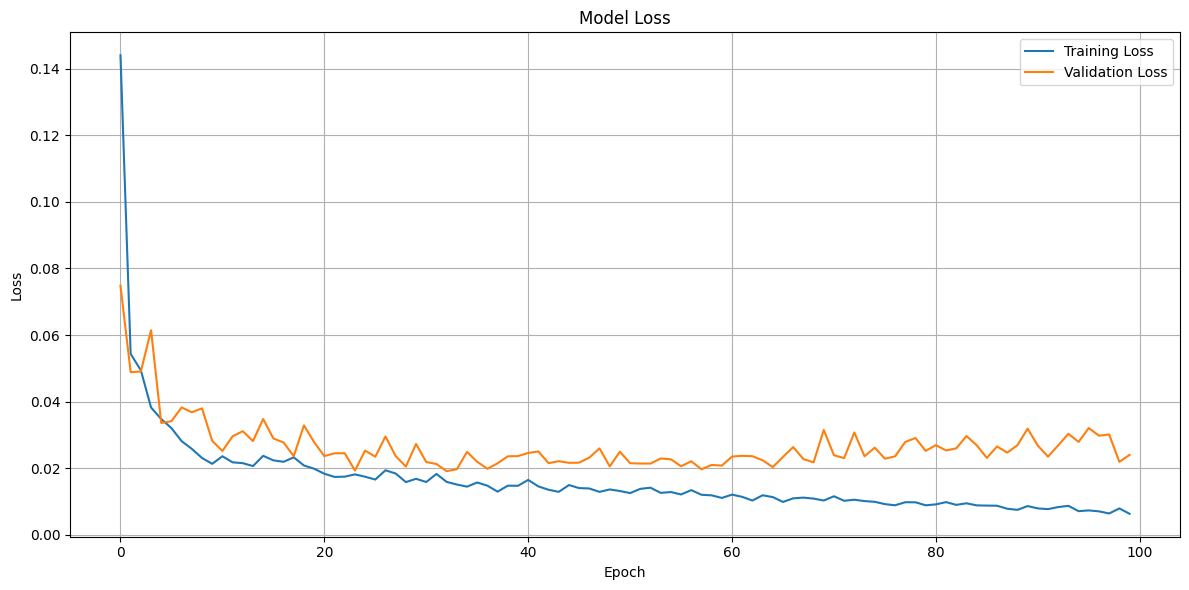

Best Hyperparameters: {'num_gru_layers': 2, 'gru_units_0': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'gru_units_1': 64, 'gru_units_2': 96}
Final Training Loss: 0.0063
Final Validation Loss: 0.0240
Final Training MAE: 0.0598
Final Validation MAE: 0.1251


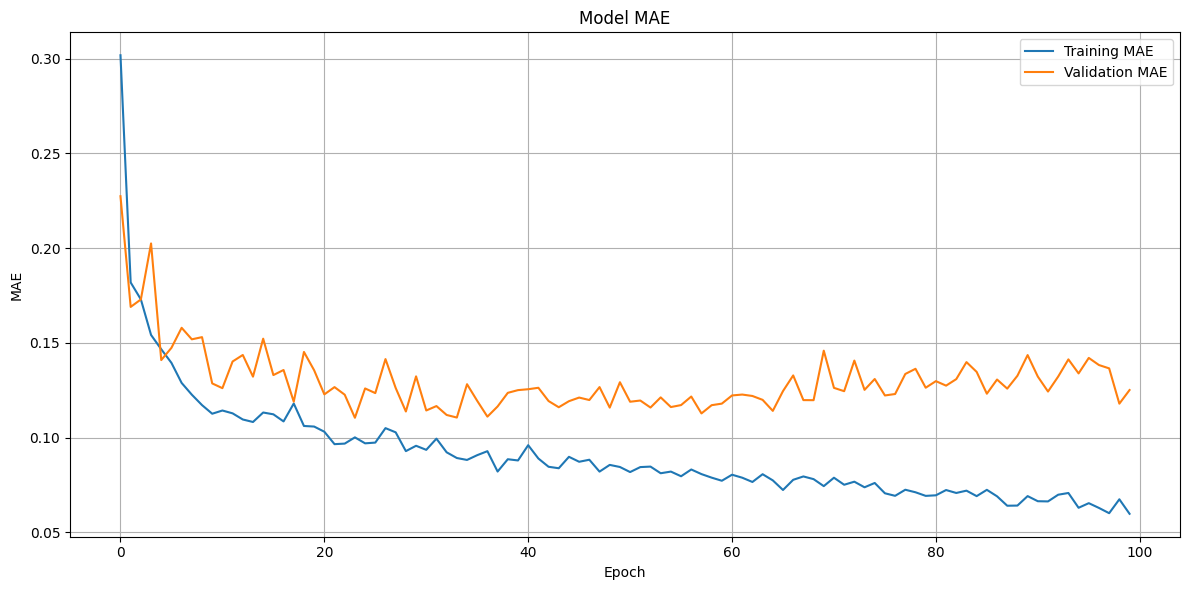

In [9]:
#plot the loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#print the best hyperparameters
print(f"Best Hyperparameters: {best_hps.values}")
# print the loss and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
# print the MAE and validation MAE
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")
#plot the MAE and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Model MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
